In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_period(N, a):

    N = N
    a = a

    xvals = np.arange(N)
    yvals = [np.mod(a**x, N) for x in xvals]

    plt.plot(xvals, yvals, lw=1, ls='dotted', marker='x')

    plt.title(f"Periodic Function of ${a}^x$ mod ${N}$")

    plt.show()

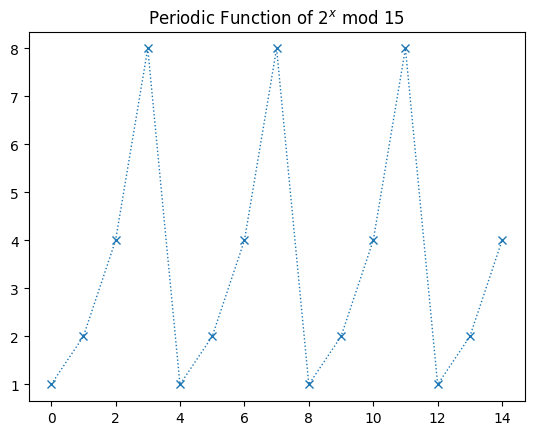

In [3]:
plot_period(15,2)

In [4]:
from qiskit import QuantumCircuit

def modular_exponentiation(N, a, power, n_qubits):
    '''
    거듭제곱 연산: U|x> = a^x mod N
    '''
    U = QuantumCircuit(n_qubits)
    for _ in range(power):
        # for i in range(n_qubits - 1):
        #     U.cx(i, i+1)
        U.unitary([[1, 0], [0, np.exp(2j * np.pi * a / N)]], [n_qubits-1], label=f"U(${a}^{power}$ mod {N})")
    
    return U

def qft_inverse(n):
    """
    QFT 역 변환
    """
    qc = QuantumCircuit(n)
    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    for j in range(n):
        for k in range(j):
            qc.cp(-np.pi / float(2 ** (j - k)), k, j)
        qc.h(j)
    return qc

def qpe_amodN(N, a):

    n_count = int(np.ceil(np.log2(N))) # QFT Register
    qc = QuantumCircuit(n_count+1, n_count)

    # Initial State (Hadamard Gate)
    for q in range(n_count):
        qc.h(q)

    qc.x(n_count)

    for q in range(n_count):
        qc.append(modular_exponentiation(N, a, 2**q, n_count+1), [*range(n_count+1)])
        qc.barrier()
    
    qc.append(qft_inverse(n_count), range(n_count))
    qc.measure(range(n_count), range(n_count))
    
    return qc

In [5]:
import random
from math import gcd
from fractions import Fraction
from qiskit_ibm_runtime.fake_provider import FakeKolkataV2
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
import pandas as pd
import heapq

def shor(N, backend=FakeKolkataV2()):
    ATTEMPT = 0

    tried_a = set()

    history = []

    while True:
        ATTEMPT += 1
        print(f"{ATTEMPT}번째 시도")
        a = random.randint(2, N-1)
        # a=7

        if a in tried_a: # 중복 확인인
            continue
        tried_a.add(a)
        print(f'고른 a는 {a}')
        if gcd(a, N) != 1:
            factor = gcd(a, N)
            print("Lucky Choice!")
            print(factor, N//factor)
        
        print(f"a={a}, 바로 못 찾았으니 양자를 이용해서...")

        qc = qpe_amodN(N, a)

        transpiled_qc = transpile(qc, backend)

        sampler = Sampler(backend)
        job = sampler.run([(transpiled_qc, [])], shots=5000)
        result = job.result()
        counts = result[0].data.c.get_counts()
        
        phase_data = []
        num_qubits = len(next(iter(counts.keys())))
        r_candidates = {}

        for key, value in counts.items():
            decimal = int(key, 2)
            phase = decimal / (2 ** num_qubits)
            fraction_phase = Fraction(phase).limit_denominator(N)
            r = fraction_phase.denominator
            phase_data.append([
                f"{key} (bin) = {decimal} (dec)", 
                f"{decimal}/{2**len(key)} = {phase:.2f}", 
                f"{fraction_phase.numerator}/{fraction_phase.denominator}", 
                f"{r}",
                f"{counts[key]}"
                ])

            if r in r_candidates:
                r_candidates[r] += value
            else:
                r_candidates[r] = value

        df = pd.DataFrame(phase_data, columns=["Register Output", "Phase", "Fraction", "r(Guess)", "Counts"])
        print(df)

        print(r_candidates)

        best_r = [k for k, v in r_candidates.items() if v == heapq.nlargest(2, r_candidates.values())[1]][0]
        
        print(f"Most common period candidate: r = {best_r}")
        history.append([a, best_r])  # 선택한 a와 r을 기록

        if best_r % 2 != 0 :
            print(f"주기(r) = {best_r}, 홀수이므로 다시")
            continue

        if pow(a, best_r, N) != 1:
            print(f"조건 : ${a}^{best_r}mod{N}$ = 1  을 만족하지 않으므로 다시시")
            continue

        factor1 = gcd(a ** (best_r // 2) - 1, N)
        factor2 = gcd(a ** (best_r // 2) + 1, N)

        if factor1 in [1, N] or factor2 in [1, N]:
            continue
        

        history_df = pd.DataFrame(history, columns=["a (Chosen)", "r (Guess)"])
        print("고른 a와 추정한 주기(r):")
        print(history_df)

        return factor1, factor2

In [6]:
N = 15
shor(N)

1번째 시도
고른 a는 3
Lucky Choice!
3 5
a=3, 바로 못 찾았으니 양자를 이용해서...
         Register Output         Phase Fraction r(Guess) Counts
0   0000 (bin) = 0 (dec)   0/16 = 0.00      0/1        1   4522
1   1000 (bin) = 8 (dec)   8/16 = 0.50      1/2        2    107
2   0010 (bin) = 2 (dec)   2/16 = 0.12      1/8        8     65
3  1110 (bin) = 14 (dec)  14/16 = 0.88      7/8        8     34
4   0100 (bin) = 4 (dec)   4/16 = 0.25      1/4        4    124
5   0001 (bin) = 1 (dec)   1/16 = 0.06     1/15       15     26
6  1100 (bin) = 12 (dec)  12/16 = 0.75      3/4        4     83
7   0101 (bin) = 5 (dec)   5/16 = 0.31     4/13       13      3
8   0110 (bin) = 6 (dec)   6/16 = 0.38      3/8        8     11
9  1010 (bin) = 10 (dec)  10/16 = 0.62      5/8        8     25
{1: 4522, 2: 107, 8: 135, 4: 207, 15: 26, 13: 3}
Most common period candidate: r = 4
조건 : $3^4mod15$ = 1  을 만족하지 않으므로 다시시
2번째 시도
고른 a는 13
a=13, 바로 못 찾았으니 양자를 이용해서...
         Register Output         Phase Fraction r(Guess) Counts
0   00

(3, 5)

In [7]:
N = 15

shor(N)

1번째 시도
고른 a는 7
a=7, 바로 못 찾았으니 양자를 이용해서...
          Register Output         Phase Fraction r(Guess) Counts
0    0000 (bin) = 0 (dec)   0/16 = 0.00      0/1        1   4494
1    0100 (bin) = 4 (dec)   4/16 = 0.25      1/4        4    113
2    0010 (bin) = 2 (dec)   2/16 = 0.12      1/8        8     87
3   1010 (bin) = 10 (dec)  10/16 = 0.62      5/8        8     33
4    1000 (bin) = 8 (dec)   8/16 = 0.50      1/2        2    108
5   1100 (bin) = 12 (dec)  12/16 = 0.75      3/4        4     94
6   1110 (bin) = 14 (dec)  14/16 = 0.88      7/8        8     28
7    0001 (bin) = 1 (dec)   1/16 = 0.06     1/15       15     28
8    0110 (bin) = 6 (dec)   6/16 = 0.38      3/8        8     11
9   1011 (bin) = 11 (dec)  11/16 = 0.69     9/13       13      1
10  1111 (bin) = 15 (dec)  15/16 = 0.94    14/15       15      2
11   1001 (bin) = 9 (dec)   9/16 = 0.56      5/9        9      1
{1: 4494, 4: 207, 8: 159, 2: 108, 15: 30, 13: 1, 9: 1}
Most common period candidate: r = 4
고른 a와 추정한 주기(r):
   a 

(3, 5)